In [1]:
import re
from os import path

import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandarallel import pandarallel

from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.model_selection import (
    train_test_split,
    learning_curve,
    RandomizedSearchCV,
)
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


# Carregar os dados

## Tweets

In [3]:
# Definir caminho do arquivo
filename = "labeled_data.parquet.gzip"
directory = "data"
filepath = path.join(directory, filename)

# Carregar dados
data = pd.read_parquet(filepath)

# Amostra dos dados
data.sample(10)

,id,text,score,label
156469,1559879411717079042,bom dia yags. e não yags.♥️✨,1.010209,1
587606,1160751961341407233,vc me odeia 😔,-0.146058,-1
724647,1160988931380457472,até agr não consegui levantar da cama 😩,-0.368363,-1
247490,1559916251283161088,a minha ta assim 💀,-0.208333,-1
230194,1559909864503230470,"genteee, eu quero um cachorro 😩😩😩 bonitinho, p...",-2.210177,-1
100460,1559849847162900483,de nada 😉🖖🏻,0.464168,1
136030,1559869574664912903,"pega essa dica, cadastre seu e-mail no rodapé ...",0.656017,1
674331,1160919746684084225,ainn bom de ter menina que a gente faz de bone...,0.677937,1
732309,1161002306814566401,tchauzinho twitter ✋,0.126984,0
515163,1160698756058288128,"acho muito lindo mina com piercing no peito, m...",0.677937,1


## Limpeza de Dados

No modelo Soma das Frequencias*, precisamos saber a quantidade de determinadas palavras que aparecem em tweets positivos, negativos e neutros.

Removeremos as Stopwords (palavras que não adicionam muito significado ao texto).

Para melhorar o modelo, utilizaremos o Stemming, que visa remove alguns [afixos](https://pt.wikipedia.org/wiki/Afixo) das palavras. Exemplo: papel gramatical, tempo, morfologia derivacional, deixando apenas o radical da palavra.
Assim, contaremos apenas os radicais das palavras em vez de suas derivações.

Referências:

- [StopWords](https://en.wikipedia.org/wiki/Stop_word)
- [Stemming](https://en.wikipedia.org/wiki/Stemming)

In [4]:
def preprocess_data(string, stopwords, stemmer=None):

    # Remover os Emojis e Pontuações
    string_tratada = re.sub("\W", " ", string)

    # Remover stopwords
    string_tratada = " ".join(
        [
            substring
            for substring in string_tratada.split()
            if substring not in stopwords
        ]
    )

    # Stemming
    if stemmer:
        string_tratada = " ".join(
            [stemmer.stem(substring) for substring in string_tratada.split()]
        )

    # Remover espaços extras
    string_tratada = re.sub(" +", " ", string_tratada)
    string_tratada = re.sub("(^ )", "", string_tratada)
    string_tratada = re.sub("( $)", "", string_tratada)

    return string_tratada

In [5]:
# Obter as stopwords
portuguese_stopwords = nltk.corpus.stopwords.words("portuguese")

# Inicializar o Stemmer
rlp_stemmer = nltk.stem.RSLPStemmer()

In [6]:
# Mostra das stopwords
pd.Series(portuguese_stopwords).sample(5)

181    teríamos
204        você
53       esteve
131        numa
168         tem
dtype: object

### Demonstração do Tratamento

In [7]:
tweet = data["text"].sample(1).values[0]
tweet_limpo = preprocess_data(tweet, portuguese_stopwords)
tweet_limpo_stemmed = preprocess_data(tweet, portuguese_stopwords, rlp_stemmer)

print("Tweet Original: {}".format(tweet))
print("")
print("Tweet Limpo   : {}".format(tweet_limpo))
print("")
print("Tweet Stemed  : {}".format(tweet_limpo_stemmed))

Tweet Original: amanhã tem abertura dos jogos e eu mal consigo ficar de pé 😒

Tweet Limpo   : amanhã abertura jogos mal consigo ficar pé

Tweet Stemed  : amanhã abert jog mal consig fic pé


## Aplicação da Limpeza

In [8]:
data["cleaned"] = data["text"].parallel_apply(
    lambda x: preprocess_data(x, portuguese_stopwords, rlp_stemmer)
)

In [9]:
data.sample(5)

,id,text,score,label,cleaned
400290,1160307264319827969,goool do santos! ⚽ raniel (contra) ⏰ ' do °t s...,0.622074,1,goool sant raniel contr t paul x sant
165005,1559883381005029376,eu disse que ele só ia postar foto quando tive...,0.484211,1,diss ia post fot volt pra core
623437,1160844627940958209,"bom dia a todos vocês, aproveitando minha folg...",0.484211,1,bom dia tod aproveit folg segund
486603,1160643761673777152,hahaha teamo juntinho pra gente n se separar n...,0.712625,1,hahah te junt pra gent n separ nunc to brinc
341295,1559979559868669958,não acredito que cancelaram young justice💔,-0.121951,-1,acredit cancel young just


# Engenharia de Atributos: Count Vectorizer

Este modelo utiliza uma matriz esparsa com a frequencia de cada palavra.

### Separar conjuntos de treinamento e teste

Aqui faremos a separação de conjunto de treino e teste.

O dicionário será criado utilizando o conjunto de treino, e posteriormente verificado sua eficácia no conjunto de teste.

In [10]:
X_train, X_test = train_test_split(data, random_state=42)

### Count Vectorizer

In [11]:
vectorizer = CountVectorizer(ngram_range=(1, 2))
vectorizer.fit(X_train["cleaned"])

CountVectorizer(ngram_range=(1, 2))

#### Aplicar a Geração do Feature Vector em todo o Dataset de Treino

In [12]:
X_features_train = vectorizer.transform(X_train["cleaned"])
y_features_train = X_train["label"]

#### Aplicar a Geração do Feature Vector em todo o Dataset de Teste

In [13]:
X_features_test = vectorizer.transform(X_test["cleaned"])
y_features_test = X_test["label"]

## Seleção de Atributos

Referência:

- [https://en.wikipedia.org/wiki/Feature_selection](https://en.wikipedia.org/wiki/Feature_selection)
- [https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection](https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection)

In [14]:
selector = SelectPercentile(f_classif, percentile=50)

selector.fit(X_features_train, y_features_train)

SelectPercentile(percentile=50)

In [15]:
X_features_train_selected = selector.transform(X_features_train)
X_features_test_selected = selector.transform(X_features_test)

## Feature Scaling

Aqui vamos normalizar os dados utilizando o Standard Scaler


Referências:
 - [https://en.wikipedia.org/wiki/Normalization_(statistics)](https://en.wikipedia.org/wiki/Normalization_(statistics))
 - [https://en.wikipedia.org/wiki/Standard_score](https://en.wikipedia.org/wiki/Standard_score)
 - [https://scikit-learn.org/stable/modules/preprocessing.html#standardization-or-mean-removal-and-variance-scaling](https://scikit-learn.org/stable/modules/preprocessing.html#standardization-or-mean-removal-and-variance-scaling)

In [16]:
# Inicializar o Scaler
scaler = StandardScaler(with_mean=False)

# Treinar o Scaler
scaler.fit(X_features_train_selected)

StandardScaler(with_mean=False)

In [17]:
# Transformar o conjunto de treinamento
X_features_train_scaled = scaler.transform(X_features_train_selected)

In [18]:
X_features_test_scaled = scaler.transform(X_features_test_selected)

# Learning


## Baseline Score

Aqui vamos, criar um score de base. Ou seja, o resultado que conseguiriamos com o menor esforço possível (que é atribuir indiscriminadamente qualquer valor)

Referências:
- [https://scikit-learn.org/stable/modules/model_evaluation.html#precision-recall-f-measure-metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#precision-recall-f-measure-metrics)

In [19]:
# Assumindo tudo como 0
score_assumindo_tudo_neutro = f1_score(
    y_features_train, [0 for _ in y_features_train], average="macro"
)

print("F-Score: {:.2f}%".format(score_assumindo_tudo_neutro * 100))

F-Score: 8.41%


In [20]:
# Assumindo tudo como -1
score_assumindo_tudo_negativo = f1_score(
    y_features_train, [-1 for _ in y_features_train], average="macro"
)

print("F-Score: {:.2f}%".format(score_assumindo_tudo_negativo * 100))

F-Score: 14.25%


In [21]:
# Assumindo tudo como 1
score_assumindo_tudo_positivo = f1_score(
    y_features_train, [1 for _ in y_features_train], average="macro"
)

print("F-Score: {:.2f}%".format(score_assumindo_tudo_positivo * 100))

F-Score: 24.57%


In [22]:
# Baseline Score
baseline_score = np.max(
    [
        score_assumindo_tudo_neutro,
        score_assumindo_tudo_negativo,
        score_assumindo_tudo_positivo,
    ]
)

print("F-Score: {:.2f}%".format(baseline_score * 100))

F-Score: 24.57%


## Naive Bayes

Referências:
- [https://en.wikipedia.org/wiki/Naive_Bayes_classifier](https://en.wikipedia.org/wiki/Naive_Bayes_classifier)
- [https://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes](https://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes)

In [23]:
nb = MultinomialNB()

### Otimização de Hyperparametros

Nesse passo, vamos tentar encontrar a melhor combinação de hyperparametros para o modelo

Referências:

- [https://scikit-learn.org/stable/modules/grid_search.html#randomized-parameter-search](https://scikit-learn.org/stable/modules/grid_search.html#randomized-parameter-search)

In [24]:
params = {
    "alpha": np.sort(np.append(np.linspace(0.5, 1.5, 20), 1)),
}

clf = RandomizedSearchCV(
    nb, params, n_iter=10, scoring="f1_macro", n_jobs=-1, random_state=42
)
clf.fit(X_features_train_scaled, y_features_train)

print("Best F-Score: {:.2f}%".format(clf.best_score_ * 100))

Best F-Score: 54.98%


In [25]:
clf.best_params_

{'alpha': 1.394736842105263}

In [26]:
classifier = clf.best_estimator_

#### Comparação com Métrica base

In [27]:
print("Score Baseline : {:.2f}%".format(baseline_score * 100))
print("Score Modelo   : {:.2f}%".format(clf.best_score_ * 100))
print("Diferença      : {:.2f}%".format(np.abs(baseline_score - clf.best_score_) * 100))

Score Baseline : 24.57%
Score Modelo   : 54.98%
Diferença      : 30.41%


### Performance no Conjunto de Treino

In [28]:
y_pred = classifier.predict(X_features_train_scaled)
score = f1_score(y_features_train, y_pred, average="macro")
print("F-Score: {:.2f}%".format(score * 100))

F-Score: 84.63%


### Curva de Aprendizado

In [29]:
def plot_learning_curve(estimator, X, y, scoring):

    plt.figure(figsize=(8, 6))
    plt.title("Learning Curve")

    plt.xlabel("Training examples")
    plt.ylabel("Score: {}".format(scoring))

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, scoring=scoring, n_jobs=-1
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.ylim(round(min([np.min(train_scores), np.min(test_scores)]), 2) - 0.01, 1.01)

    plt.grid()

    plt.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )

    plt.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )

    plt.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
    plt.plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )

    plt.legend(loc="best")

    return plt

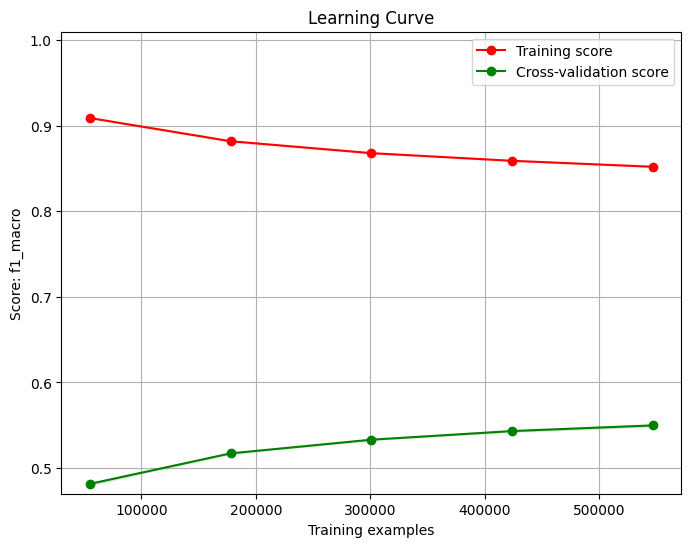

In [30]:
plt = plot_learning_curve(
    classifier, X_features_train_scaled, y_features_train, scoring="f1_macro"
)
plt.show()

## Validação em conjunto de Teste

In [31]:
y_pred = classifier.predict(X_features_test_scaled)
score = f1_score(y_features_test, y_pred, average="macro")
print("F-Score: {:.2f}%".format(score * 100))

F-Score: 47.71%


### Preditos Positivos

In [32]:
preditos_positivos = X_test[y_pred == 1]

#### Falso Positivo -> Negativo

In [33]:
preditos_positivos[preditos_positivos["label"] == -1]["text"].sample(10).values

array(['amg kakaka nem na tpm eu simto meu peitos 😭😭😭',
       'soh queria zua e anda de skate 😔', 'vamo ali cmg?😭',
       'o taehyung falando que esqueceu a senha do weverse 😭😭😭',
       'eu preciso desse primeiro take😭😭', 'dr. cruziito 😴😵\u200d💫',
       'o meu deus de quem eu vou tomar comida do prato horas da manhã 😩',
       'minha máquina pra passar cartão n chega logooo 😓',
       'mariane mentiu😡',
       'ontem na escola mlk tava sendo racista um com outro 😐🤙'],
      dtype=object)

#### Falso Positivo -> Neutro

In [34]:
preditos_positivos[preditos_positivos["label"] == 0]["text"].sample(10).values

array(['yacht de mcgregor é muito terrível 🔥',
       'samuel um mito de toda criança 😂',
       'conteúdo disponível venha na minha dm 🔞\U0001fae6 alguém querendo uma mamada curti aí 🔥',
       'e-ego? 😳', '😳 o que tem?', 'exatamente 😂',
       'a pensar se ainda dou um saltinho à praia durante a minha hora de almoço 👀',
       'sem luz e unidas 😂🥰', 'esse queima 😂 certeza',
       'sim. a maioria já tombou 😂'], dtype=object)

#### Verdadeiro Positivo

In [35]:
preditos_positivos[preditos_positivos["label"] == 1]["text"].sample(10).values

array(['no fim deu tudo certo pro doguinho 💜',
       'carinha d uma fucinho da outra kkk ❤', 'que ricura 😍',
       'owt bebês 💜', 'missão dada missão cumprida👊💀👊',
       'mano eu to apaixonada no leo e no raphael, além de cantores maravilhosos eles são super humildes. perfeitos 😍',
       '[ / : am] ❤: vou dormir, tá? [ / : am] ❤: fica com deus [ / : am] ❤: beijosss [ / : am] ❤: n de…',
       'booom ✈ boom ✈', 'somos todes mudinhas 🙊🔇',
       'oiá a mentirinha... 💛'], dtype=object)

### Preditos Negativos

In [36]:
preditos_negativos = X_test[y_pred == -1]

#### Falso Negativo -> Positivo

In [37]:
preditos_negativos[preditos_negativos["label"] == 1]["text"].sample(10).values

array(['que notícia triste 😞 que deus o receba em sua glória e dê conforto ao coração de toda família e amigos 🙌🙌',
       'no encontro vamos promover um debate sobre a leitura do capítulo (alegria completa: lesbianidade e feminismo) do livro “o feminismo é para todo mundo” de autoria de bell hooks. te esperamos aqui na nossa salinha 💙',
       'to a mais de h sem comer, será q eu passo mal, pq eu do vou almoçar ro amanfo tebtar morrer💗💗💗',
       'pai tá chato 😝', 'pqp eu sou a pior pessoa do mundo 😃',
       'nem sempre as coisas saem como a gente quer. bom dia ✨',
       'tá perdoado ja calamba 💙',
       'meu bebê urso, meu tesouro, minha preciosidade, meu mundo, meu tudo ♡',
       'nao sou de manaus, mas vou estar na live de olho nas minhas embaixadoras! ❤',
       'surtando com o aparelho hj! odeio usar elástico... da vontade de arrancar todos os dentes com um alicate 😊'],
      dtype=object)

#### Falso Negativo -> Neutro

In [38]:
preditos_negativos[preditos_negativos["label"] == 0]["text"].sample(10).values

array(['queria eu 😂', 'hoje eu to assim 😂', 'assim msm,pior hora 😥',
       'faltou casamento aí hein 👀',
       'certíssima! ruim é ler os comentários e ver que tem gente que tem mais medo de ter filho do que dst. 😢',
       'porra todos que reclamam é que eu conheço nasceram de uma mulher que teve relações com um homem 😂 sim os famosos “a…',
       'kakakak ultimamente tá foda 😂',
       'minha pressão foi abaixar logo hoje, to muito mal 😰',
       'preciso urgentemente me acalmar 😥',
       'não me resta mais nada pra mim 😢 feio e conto piada'],
      dtype=object)

#### Verdadeiro Negativo

In [39]:
preditos_negativos[preditos_negativos["label"] == -1]["text"].sample(10).values

array(['com soninho 😭', 'sdds poder dormir até meio dia 😩',
       'o coração tá apertadinho 😞',
       'eu tô procurando jaaa, mas tenho um puta medo de comprar aqui 😭😭',
       'eu só chego atrasada... ô ódio 😞😤', 'tô com fomeee 😣',
       'hoje nesse friozinho só faltou a morena pra assistir um filminho e me fazer carinho 💔',
       'ta me traindo 😭 so mim iludiu', 'me odeio 😔',
       'amanhã começa tudo dnv, mais um semestre 😴'], dtype=object)

### Preditos Neutros

In [40]:
preditos_neutros = X_test[y_pred == 0]

#### Falso Neutro -> Positivo

In [41]:
preditos_neutros[preditos_neutros["label"] == 1]["text"].sample(10).values

array(['alimente seu alimento 😉',
       'claro que ce nao pode participar. é corrente de sorriso, não de mulher perfeita 😍',
       'to de volta porraaa 😌',
       'ver esse top do masterchef é a definição de tanto faz que satisfação esses três 💜',
       'rudy silva meu amor. ❤',
       '🩸❤️\u200d🔥❤️\u200d🩹 de fato, os outros só tenho no wpp',
       '❤ te amo mais que chocolate (desculpa por ter comido os cookie tudinho)',
       'ontem eu estava tão estanho, e hoje tão bem, deus é muito bom 🙏',
       'queria saber, se a sinopse pode ultrapassar o números de linhas limite do tt? 🤔 apesar de ser curta, não tá cabendo 😆',
       'meu pai amou a camisa do flamengo que dei pra ele 😍'],
      dtype=object)

#### Falso Neutro -> Negativo

In [42]:
preditos_neutros[preditos_neutros["label"] == -1]["text"].sample(10).values

array(['não deveria ter postado na minha conta de artes antes de desativar 😡 hitei mas a q custo',
       'meu medo é de quando ela souber tudo ela queria se afastar, e eu não quero que isso aconteça 😞',
       'entrei no sigaa e as matérias do º semestre já todas organizadas eu vou chorar sério 😭',
       'eu sou novato nisso mas banana fish... 😔',
       '💀 paus? já nem da p rir, é só ridiculo…',
       'pois é kkk todo mundo atordoado😭😭 pense!',
       'véio, tu devia me agradecer por te dá essa imagem, não para de usar ela 😭',
       'a dublagem tá ótima kkk tô rindo dos fãs chatos do harry reclamando que a voz da dublagem é de criança, deve ser em gomagem a vocês que trata esse velho como se fosse um adolescente que é obrigado a fazer coisas que não quer por causa de gestão 😔',
       'só queria dar uns beijos na morena 😩',
       'minha semana já começou uma merda pq minha casa está sem wifi novamente 😣'],
      dtype=object)

#### Verdadeiro Neutro

In [43]:
preditos_neutros[preditos_neutros["label"] == 0]["text"].sample(10).values

array(['cães são ótimos motivos para raptar criancinhas @ hugostrada olha a dica 😂',
       'heitor me orgulho hoje, parabéns filho obrigada por dormir 😂',
       'eu fico mais no tt que nas outras redes, viciei nesse bgl 😂',
       'terça | forró na savassi | h ► lista amiga no evento',
       'bom dia por favor, qlguém teria um pacote de macarrão sobrando pra me doar pra eu fazer uma sopa pra mim e pra minha mãezinha almoçar 😭? infelizmente tenho câncer em estado avançado, perdi parte da visão e audição 😔 moro com a minha mãezinha, aceito alimentos vencidos 😭🙏',
       'não brinca não pô! quer brincar, tira férias e vai curtir n venezuela, cuba, argentina, ou qq país canhoto, lá tá uma diversão 😳 😱 mas é sempre bom post comédia no tt 🤫',
       'o sting postou um "😳" no tt da los, deve ser relacionado a lol, vai tomar no cu zaraki',
       'o nome do cara é chocolover? 😂',
       'tenho interesse tem um tempinho já 👀 — hoje nao faro',
       'gente, tá sem noção nenhuma 😂'], dtype=ob